#### Importing Libraries

In [1]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.7/548.7 kB 2.3 MB/s eta 0:00:00


# Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import cv2

import timm
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

import albumentations as A
from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Dataset

#### Data Analysis
* concetto_CDT contains images of hand-drawn clock
* train_csv contain the corrsponding image id and their labels
* test_csv contain the images which needs to be predicted

In [4]:
train = pd.read_csv('../input/concetto22/train.csv')
test = pd.read_csv('../input/concetto22/test.csv')

In [5]:
train.head()

,id,tar
0,20002859.0,5.0
1,10011157.0,5.0
2,10011996.0,5.0
3,10000364.0,5.0
4,20004294.0,3.0


In [6]:
test.head()

,id
0,10002998.0
1,10003172.0
2,20004712.0
3,20004205.0
4,20000346.0


In [7]:
# This function adds an extra column having the path of the images
def append_path(df):
    target_str = []
    for i in range(len(df)):
        target_str.append(str(df['id'][i]))
    for i in range(len(df)):
        target_str[i] = target_str[i].replace('.0', '.tif') 
        target_str[i] = '/kaggle/input/concetto22/concetto_CDT/concetto_CDT/'+target_str[i]
    df['path'] = target_str
    return df

In [8]:
train = append_path(train)
train.head()

,id,tar,path
0,20002859.0,5.0,/kaggle/input/concetto22/concetto_CDT/concetto...
1,10011157.0,5.0,/kaggle/input/concetto22/concetto_CDT/concetto...
2,10011996.0,5.0,/kaggle/input/concetto22/concetto_CDT/concetto...
3,10000364.0,5.0,/kaggle/input/concetto22/concetto_CDT/concetto...
4,20004294.0,3.0,/kaggle/input/concetto22/concetto_CDT/concetto...


In [9]:
test = append_path(test)
test.head()

,id,path
0,10002998.0,/kaggle/input/concetto22/concetto_CDT/concetto...
1,10003172.0,/kaggle/input/concetto22/concetto_CDT/concetto...
2,20004712.0,/kaggle/input/concetto22/concetto_CDT/concetto...
3,20004205.0,/kaggle/input/concetto22/concetto_CDT/concetto...
4,20000346.0,/kaggle/input/concetto22/concetto_CDT/concetto...


#### Data visualization

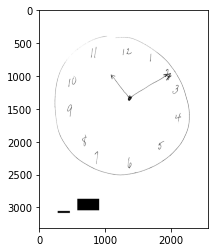

In [10]:
plt.imshow(cv2.imread(train['path'][0]))

#### Splitting the train data into train and val set

In [11]:
X = train.drop(['tar'], axis=1)
y = train['tar']
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify = y)

In [12]:
train_data = pd.merge(x_train, y_train, right_index=True, left_index=True)
val_data = pd.merge(x_val, y_val, right_index=True, left_index=True)

In [13]:
#defining a configuration

class CFG:
    model_name = 'resnet18'
    target_size = 6
    size = 256
    batch_size = 64
    epochs = 10
    num_workers = 2
    lr = 1e-3
    weight_decay = 1e-2
    train = True
    target_col = 'tar'

#### Dataset creation 
Creating a custom dataset for training and test data which takes path of images, transforms it and converts the image to tensors for further processing.

In [14]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['path'].values
        self.labels = df['tar'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = file_name
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label
    

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['path'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = file_name
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

# Transformation

#### Augmentation
Applying some necessary augmentations like resizing the image to the size accepted by model, Normalizing the tensors.
Albumentations like RandomResizedCrop and HorizontalFlip are used to augment the dataset.
Find more albumentations [here](https://github.com/pytorch/vision/blob/main/torchvision/transforms/transforms.py)

In [15]:
# Transforms
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.RandomResizedCrop(CFG.size, CFG.size),
            A.HorizontalFlip(p=0.5),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

# Model

In [16]:
class CustomNet(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(CFG.model_name, pretrained=pretrained)
        #print(self.model.default_cfg["classifier"])
        n_features = self.model.fc.in_features #either fc or classifier , check using above line
        self.model.classifier = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x
    

In [17]:
model = CustomNet(model_name=CFG.model_name, pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


## Loss Function
The loss function used, here [CrossEntropyLoss.](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

In [18]:
def get_criterion():
    criterion = nn.CrossEntropyLoss()
    return criterion

In [19]:
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

## Optimizer

In [20]:
def get_optimizer(model):
    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    return optimizer

## Scheduler
It is used for adjusting the learning rate(LR decay) between epochs as the training progresses. Read about more schedulers [here](https://pytorch.org/docs/stable/optim.html#)

In [21]:
def get_scheduler(optimizer):
    scheduler = StepLR(optimizer, step_size=2, gamma=0.41, verbose=True)
    return scheduler

## Utility Functions

In [22]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train() # switch to training mode
    running_loss = 0
    count = 0
    for (images, labels) in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        y_preds = model(images)
        
        loss = criterion(y_preds, labels)
        running_loss += loss.item()*labels.shape[0]
        count += 1
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    return running_loss/count


def valid_fn(valid_loader, model, criterion, device):
    model.eval() # switch to evaluation mode
    preds = []
    running_loss = 0
    count = 0
    
    for (images, labels) in tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        running_loss += loss.item()*labels.shape[0]
        count += 1
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
    predictions = np.concatenate(preds)
    
    return (running_loss/count), predictions


def test_fun(test_loader, model, device):
    model.eval()
    preds = []
    test_df = pd.DataFrame()
    for step, (images) in enumerate(test_loader):
        images = images.to(device)
        with torch.no_grad():
            y_preds = model(images)
        preds.append(y_preds.softmax(1).to('cpu').numpy())
    predictions = np.concatenate(preds)
    pred = predictions.argmax(1)
    return pred

# Train loop

In [23]:
# Train loop
def train_loop(train_data, valid_data):
    
    # create dataset
    train_dataset = TrainDataset(train_data, transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_data, transform=get_transforms(data='valid'))

    # create dataloader
    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # create model and transfer to device
    model = CustomNet(CFG.model_name, pretrained=True)
    model.to(device)
    
    # select optimizer, scheduler and criterion
    optimizer = get_optimizer(model)
    scheduler = get_scheduler(optimizer)
    criterion = get_criterion()

    best_score = -1.0
    best_loss = np.inf
    
    # start training
    for epoch in range(CFG.epochs):
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)
        # validation
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
#         valid_labels = valid_folds[CFG.target_col].values
        valid_labels = valid_data['tar']
        
        scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))
        print("score: ", score)

        # code for saving the best model
        if score > best_score:
            print('Score Improved')
            best_score = score
            print(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f}')
            torch.save({'model': model.state_dict(), 
                        'preds': preds,
                        'optimizer': optimizer.state_dict(),
                        'scheduler': scheduler.state_dict()},
                        './'+f'{CFG.model_name}_best.pth')
    
    check_point = torch.load('./'+f'{CFG.model_name}_best.pth')
    valid_data['preds'] = check_point['preds'].argmax(1)

    return valid_data

In [24]:
# main
def main():
    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
    
    if CFG.train: 
        # train
        df = train_loop(train_data, val_data)
        get_result(df)

In [25]:
if __name__ == '__main__':
    main()

Adjusting learning rate of group 0 to 1.0000e-03.


100%|██████████| 4/4 [00:10<00:00,  2.71s/it]


Adjusting learning rate of group 0 to 1.0000e-03.
score:  0.3700787401574803
Score Improved
Epoch 1 - Save Best Score: 0.3701


100%|██████████| 4/4 [00:11<00:00,  2.84s/it]


Adjusting learning rate of group 0 to 4.1000e-04.
score:  0.37401574803149606
Score Improved
Epoch 2 - Save Best Score: 0.3740


100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


Adjusting learning rate of group 0 to 4.1000e-04.
score:  0.49606299212598426
Score Improved
Epoch 3 - Save Best Score: 0.4961


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


Adjusting learning rate of group 0 to 1.6810e-04.
score:  0.41338582677165353


100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


Adjusting learning rate of group 0 to 1.6810e-04.
score:  0.5393700787401575
Score Improved
Epoch 5 - Save Best Score: 0.5394


100%|██████████| 4/4 [00:11<00:00,  2.83s/it]


Adjusting learning rate of group 0 to 6.8921e-05.
score:  0.547244094488189
Score Improved
Epoch 6 - Save Best Score: 0.5472


100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


Adjusting learning rate of group 0 to 6.8921e-05.
score:  0.562992125984252
Score Improved
Epoch 7 - Save Best Score: 0.5630


100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


Adjusting learning rate of group 0 to 2.8258e-05.
score:  0.5787401574803149
Score Improved
Epoch 8 - Save Best Score: 0.5787


100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


Adjusting learning rate of group 0 to 2.8258e-05.
score:  0.5905511811023622
Score Improved
Epoch 9 - Save Best Score: 0.5906


100%|██████████| 4/4 [00:11<00:00,  2.81s/it]


Adjusting learning rate of group 0 to 1.1586e-05.
score:  0.610236220472441
Score Improved
Epoch 10 - Save Best Score: 0.6102


In [26]:
test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, 
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
check_point = torch.load('./'+f'{CFG.model_name}_best.pth')
model = CustomNet(CFG.model_name, pretrained=True)
model.to(device)
model.load_state_dict(check_point['model'])
pred = test_fun(test_loader, model, device)

In [27]:
test['tar'] = pred

In [28]:
submission_df = test.drop(['path'], axis=1)
submission_df.to_csv("solution.csv", index=False)

In [29]:
submission_df

,id,tar
0,10002998.0,3
1,10003172.0,4
2,20004712.0,4
3,20004205.0,5
4,20000346.0,3
...,...,...
553,20001798.0,4
554,10006153.0,5
555,10010660.0,4
556,10008746.0,4


### Now click on the "Submit" button to submit the notebook
### NOTE: We expect everyone to generate such notebooks for your final submission. Only the teams with notebook submitted against their final submission will be considered for prize money!

### Things to try next:
* Try different architectures, optimizers, loss functions etc.
* Think of ways of tackling data imbalance problem.
* Try different image size
* Try Ensembling methods.
* Apply semi supervised learning.

### PS: This competition is hosted to promote learning. So we request you to publish your baseline models via Kaggle kernels and discuss on the discussion tab to help others learn. Thanks!